In [1]:
import timeit
import datetime as dt
import os
import subprocess 

import pandas as pd
import numpy as np



#visualization
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline
import seaborn as sns

#to get financial data
from pandas_datareader import data as pdr


#for webscraping 
import requests
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import requests


#for pdf report generation
from reportlab.pdfgen import canvas
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter, landscape
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.platypus.tableofcontents import TableOfContents


/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
days_to_lookback = 5

In [3]:
date_end = dt.datetime.today()
date_start = date_end - dt.timedelta(days_to_lookback)

# Create timestamped folder to save reports created later

In [4]:
#timestamp = str(dt.datetime.now()) <- '2020-06-26 20:26:08.775766'  
timestamp =  dt.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
timestamp

'2020-06-29 17-17-02'

In [5]:
path = os.getcwd() 
reportDir = os.path.join(path,timestamp)
reportDir

'/Users/reejungkim/Documents/Git/reporting automation/2020-06-29 17-17-02'

In [6]:
#create named folder
os.makedirs(reportDir, exist_ok = False)

In [7]:
os.chdir(reportDir)

# Web scraping S&P100 companies from Wikipedia table

In [8]:
website_url = requests.get("https://en.wikipedia.org/wiki/S%26P_100").text

soup = BeautifulSoup(website_url,'lxml')
#print(soup.prettify())

In [9]:
wiki_table = soup.find('table',{'class':'wikitable sortable'})

In [10]:
data = []
tHeader = []
SP100_tickers = pd.DataFrame()

for tr in wiki_table.find_all("tr"):
    for th in tr.find_all("th")[:1]:
        tHeader = th.get_text(strip=True)
        SP100_tickers[tHeader] = []
    for td in tr.find_all("td")[:1]:
        data.append( td.get_text(strip=True))
        
SP100_tickers[tHeader] = data

In [11]:
SP100_tickers

,Symbol
0,AAPL
1,ABBV
2,ABT
3,ACN
4,ADBE
...,...
96,VZ
97,WBA
98,WFC
99,WMT


# Use DataReader to get financial data of S&P100 companies from yahoo

In [12]:
%%time

df = pd.DataFrame()

for i in data:
    symbol = SP100_tickers.loc[SP100_tickers['Symbol']==i]
    try:
        symbol_data = pdr.DataReader(i, 'yahoo', date_start, date_end).reset_index()
        #display(symbol_data)  
    except: 
        print(i + " - Err")
        symbol_data = pd.DataFrame()
        pass
    single_table = pd.concat([symbol, symbol_data], axis=0, ignore_index=True) #axis=0 <- row. add frames by row and use fill down.
    single_table['Symbol'].ffill(inplace=True)
    df = df.append(single_table)
    

BRK.B - Err
CPU times: user 8.02 s, sys: 625 ms, total: 8.65 s
Wall time: 1min 3s


In [13]:
df = df.loc[df['Date'].notnull()]

In [14]:
df = df.reset_index(drop=True)

df.groupby(['Symbol']).describe().transpose()

In [15]:
df_Flat = df

# Analytics

###  main data frames to be used: 
#### 1. df_Flat
#### 2. df  
#### 3. df_Flat_pct_change

In [16]:
df_Flat

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-24,368.790009,358.519989,365.000000,360.059998,48155800.0,360.059998
1,AAPL,2020-06-25,365.000000,357.570007,360.700012,364.839996,34380600.0,364.839996
2,AAPL,2020-06-26,365.320007,353.019989,364.410004,353.630005,51270100.0,353.630005
3,AAPL,2020-06-29,360.949890,351.299988,353.250000,360.299896,17069627.0,360.299896
4,ABBV,2020-06-24,97.160004,94.349998,96.459999,95.139999,9025100.0,95.139999
...,...,...,...,...,...,...,...,...
395,WMT,2020-06-29,119.669998,118.220001,118.500000,118.860001,2292535.0,118.860001
396,XOM,2020-06-24,45.959999,44.250000,45.910000,44.500000,27626900.0,44.500000
397,XOM,2020-06-25,45.240002,43.689999,44.049999,45.169998,19353600.0,45.169998
398,XOM,2020-06-26,44.939999,43.500000,44.880001,43.619999,31501700.0,43.619999


In [17]:
df = df.groupby(['Symbol', 'Date']).sum()

df

High         Low        Open       Close      Volume  \
Symbol Date                                                                     
AAPL   2020-06-24  368.790009  358.519989  365.000000  360.059998  48155800.0   
       2020-06-25  365.000000  357.570007  360.700012  364.839996  34380600.0   
       2020-06-26  365.320007  353.019989  364.410004  353.630005  51270100.0   
       2020-06-29  360.949890  351.299988  353.250000  360.299896  17069627.0   
ABBV   2020-06-24   97.160004   94.349998   96.459999   95.139999   9025100.0   
...                       ...         ...         ...         ...         ...   
WMT    2020-06-29  119.669998  118.220001  118.500000  118.860001   2292535.0   
XOM    2020-06-24   45.959999   44.250000   45.910000   44.500000  27626900.0   
       2020-06-25   45.240002   43.689999   44.049999   45.169998  19353600.0   
       2020-06-26   44.939999   43.500000   44.880001   43.619999  31501700.0   
       2020-06-29   44.389999   43.540001   43.810001   44.185001   8032233.0   

                    Adj Close  
Symbol Date                    
AAPL   2020-06-24  360.059998  
       2020-06-25  364.839996  
       2020-06-26  353.630005  
       2020-06-29  360.299896  
ABBV   2020-06-24   95.139999  
...                       ...  
WMT    2020-06-29  118.860001  
XOM    2020-06-24   44.500000  
       2020-06-25   45.169998  
       2020-06-26   43.619999  
       2020-06-29   44.185001  

[400 rows x 6 columns]

In [18]:
df_Flat_pct_change = pd.DataFrame()

for i in df_Flat.columns.tolist():
    if i !="Symbol" and i!="Date" :
        data = df_Flat.groupby('Symbol')[i].pct_change()
        df_Flat_pct_change[i] = data

df_Flat_pct_change['Symbol'] = df_Flat['Symbol']
df_Flat_pct_change['Date'] = df_Flat['Date']

df_Flat_pct_change
cols = df_Flat.columns.tolist()
df_Flat_pct_change = df_Flat_pct_change[cols]

df_Flat_pct_change

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
0,AAPL,2020-06-24,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2020-06-25,-0.010277,-0.002650,-0.011781,0.013276,-0.286055,0.013276
2,AAPL,2020-06-26,0.000877,-0.012725,0.010286,-0.030726,0.491251,-0.030726
3,AAPL,2020-06-29,-0.011962,-0.004872,-0.030625,0.018861,-0.667065,0.018861
4,ABBV,2020-06-24,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
395,WMT,2020-06-29,-0.009682,0.001695,-0.009197,0.004564,-0.745084,0.004564
396,XOM,2020-06-24,NaN,NaN,NaN,NaN,NaN,NaN
397,XOM,2020-06-25,-0.015666,-0.012655,-0.040514,0.015056,-0.299465,0.015056
398,XOM,2020-06-26,-0.006631,-0.004349,0.018842,-0.034315,0.627692,-0.034315


In [19]:
df_temp = df.unstack(level=0).pct_change()  #df.groupby(['Symbol', 'Date']).sum().pct_change()

df_temp

High                                                    \
Symbol          AAPL      ABBV       ABT       ACN      ADBE       AIG   
Date                                                                     
2020-06-24       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-25 -0.010277 -0.000926 -0.010140  0.050579 -0.010572 -0.009482   
2020-06-26  0.000877 -0.000412  0.001559 -0.004406  0.000434 -0.014678   
2020-06-29 -0.011962  0.002989 -0.003947 -0.016319 -0.022137  0.000000   

                                                    ... Adj Close            \
Symbol           ALL      AMGN       AMT      AMZN  ...       UNH       UNP   
Date                                                ...                       
2020-06-24       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2020-06-25 -0.000209 -0.006582 -0.027510 -0.014224  ...  0.024345  0.008879   
2020-06-26 -0.001877  0.006031  0.008400  0.009557  ... -0.031531 -0.026224   
2020-06-29  0.001881 -0.011484 -0.015382 -0.032549  ...  0.013176  0.011190   

                                                                        \
Symbol           UPS       USB         V        VZ       WBA       WFC   
Date                                                                     
2020-06-24       NaN       NaN       NaN       NaN       NaN       NaN   
2020-06-25  0.009315  0.032004  0.013427  0.006490  0.021132  0.047856   
2020-06-26 -0.028954 -0.052300 -0.024281 -0.020634 -0.020695 -0.074169   
2020-06-29  0.017704  0.013468  0.003910  0.014391  0.026476  0.007502   

                                
Symbol           WMT       XOM  
Date                            
2020-06-24       NaN       NaN  
2020-06-25 -0.004904  0.015056  
2020-06-26 -0.011611 -0.034315  
2020-06-29  0.004564  0.012953  

[4 rows x 600 columns]

## Functions defined

In [20]:
def format_column_number(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col]= pd.Series([round(val, 2 ) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
            pass
    return dataframe

def format_column_percentage(dataframe, listCols):
    for col in listCols:
        try:
            dataframe[col] = pd.Series(["{0:.2f}%".format(val*100) for val in dataframe[col]], index= dataframe.index)
        except ValueError:  #skips error when the column is in format already
            dataframe[col] = dataframe[col]
        
    return dataframe

In [21]:
def CreatePctPlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df_Flat_pct_change.groupby(['Symbol', 'Date']).sum().loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)
    #plt.tight_layout()

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

def CreatePlotAndSavefig(listTickers, stringTitle, stringYlabel, jpg_name):
    sns.relplot(x='Date', y='Close', kind='line', hue ='Symbol',data=df.loc[listTickers].reset_index()).fig.autofmt_xdate()
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
    plt.title(stringTitle, fontsize=16)
    plt.ylabel(stringYlabel, fontsize=14)
    plt.xlabel('Date', fontsize=14)

    jpg_name = jpg_name + '.jpg'
    plt.savefig(jpg_name, bbox_inches='tight')

### Best performed tickers based on percentage of of growth

In [22]:
tickers_bestPerformed = df_temp['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5) #df_pct_change['Close'].describe().transpose().sort_values(by='mean', ascending=False).head(5)

In [23]:
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
DOW,3.0,0.022316,0.023579,-0.004502,0.013578,0.031658,0.035725,0.039792
ACN,3.0,0.018220,0.051886,-0.022317,-0.011017,0.000282,0.038488,0.076694
SPG,3.0,0.011904,0.067161,-0.046812,-0.024712,-0.002611,0.041262,0.085136
LLY,3.0,0.010206,0.023516,-0.006326,-0.003255,-0.000184,0.018471,0.037127
ALL,3.0,0.009434,0.022029,-0.013044,-0.001341,0.010362,0.020673,0.030984


In [24]:
tickers_bestPerformed = format_column_percentage(tickers_bestPerformed, tickers_bestPerformed.columns[1:])
tickers_bestPerformed

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
DOW,3.0,2.23%,2.36%,-0.45%,1.36%,3.17%,3.57%,3.98%
ACN,3.0,1.82%,5.19%,-2.23%,-1.10%,0.03%,3.85%,7.67%
SPG,3.0,1.19%,6.72%,-4.68%,-2.47%,-0.26%,4.13%,8.51%
LLY,3.0,1.02%,2.35%,-0.63%,-0.33%,-0.02%,1.85%,3.71%
ALL,3.0,0.94%,2.20%,-1.30%,-0.13%,1.04%,2.07%,3.10%


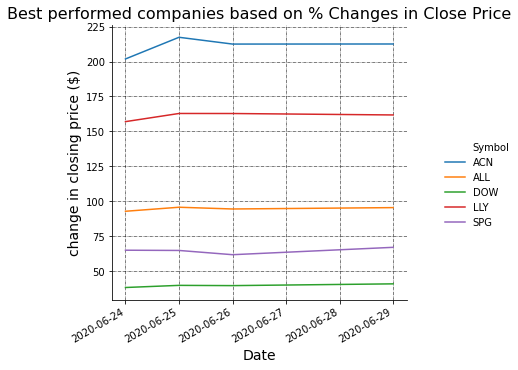

In [25]:
CreatePlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price ($)', 'highest growth closing price')

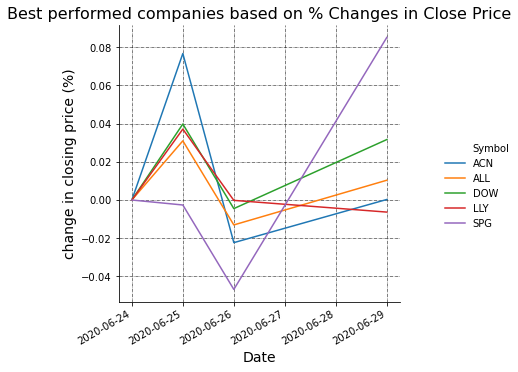

In [26]:
CreatePctPlotAndSavefig(tickers_bestPerformed.index, 'Best performed companies based on % Changes in Close Price', 'change in closing price (%)', 'highest growth closing pct change')

## Volatility

### most volatiled companies. (based on the standard deviation of percentage change)

#### Top 5 companies with highest volatillity rates among S&P 100

In [27]:
tickers_volatile = df_temp['Close'].describe().transpose().sort_values(by='std', ascending=False).head(5)#.round(2)
tickers_volatile = format_column_percentage(tickers_volatile, tickers_volatile.columns[1:])

In [28]:
tickers_volatile.index

Index(['GS', 'SPG', 'COF', 'WFC', 'NKE'], dtype='object', name='Symbol')

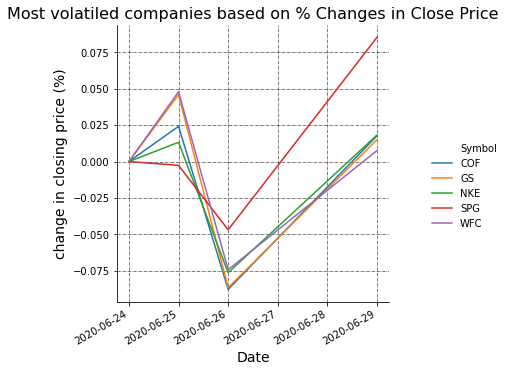

In [29]:
CreatePctPlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price (%)', '1')

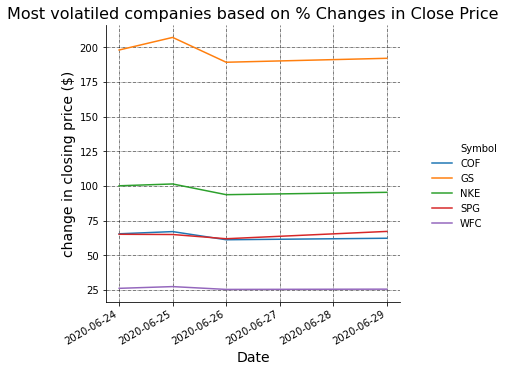

In [30]:
CreatePlotAndSavefig(tickers_volatile.index, 'Most volatiled companies based on % Changes in Close Price', 'change in closing price ($)', '2')

## Get date where highest drop and raise of closing price occured. 

In [31]:
highest_raise = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(max) == df_Flat_pct_change['Close']
df_Flat_pct_change[highest_raise]

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
3,AAPL,2020-06-29,-0.011962,-0.004872,-0.030625,0.018861,-0.667065,0.018861
5,ABBV,2020-06-25,-0.000926,-0.000318,-0.013270,0.019445,-0.289570,0.019445
9,ABT,2020-06-25,-0.010140,-0.007602,-0.037405,0.026575,-0.058744,0.026575
13,ACN,2020-06-25,0.050579,0.054863,0.036446,0.076694,0.703236,0.076694
17,ADBE,2020-06-25,-0.010572,0.000257,-0.022705,0.012208,-0.316634,0.012208
...,...,...,...,...,...,...,...,...
383,VZ,2020-06-29,0.002220,0.008704,-0.013509,0.014391,-0.809314,0.014391
387,WBA,2020-06-29,0.016933,0.016196,-0.010270,0.026476,-0.647445,0.026476
389,WFC,2020-06-25,0.014058,-0.003848,-0.037092,0.047856,-0.213986,0.047856
395,WMT,2020-06-29,-0.009682,0.001695,-0.009197,0.004564,-0.745084,0.004564


In [32]:
highest_drop = df_Flat_pct_change.groupby(['Symbol'])['Close'].transform(min) == df_Flat_pct_change['Close']
drops = df_Flat_pct_change[highest_drop]

In [33]:
drops

,Symbol,Date,High,Low,Open,Close,Volume,Adj Close
2,AAPL,2020-06-26,0.000877,-0.012725,0.010286,-0.030726,0.491251,-0.030726
6,ABBV,2020-06-26,-0.000412,0.007634,0.017966,-0.008867,1.271956,-0.008867
10,ABT,2020-06-26,0.001559,0.020659,0.029574,-0.010154,0.474097,-0.010154
14,ACN,2020-06-26,-0.004406,-0.002033,0.017746,-0.022317,-0.286086,-0.022317
18,ADBE,2020-06-26,0.000434,-0.006712,0.013930,-0.022955,0.682929,-0.022955
...,...,...,...,...,...,...,...,...
382,VZ,2020-06-26,-0.006067,-0.009186,0.002411,-0.020634,0.764001,-0.020634
386,WBA,2020-06-26,-0.008044,0.000737,0.018239,-0.020695,0.056527,-0.020695
390,WFC,2020-06-26,-0.036848,-0.024720,0.005393,-0.074169,0.797850,-0.074169
394,WMT,2020-06-26,0.005659,-0.003041,-0.001336,-0.011611,0.311627,-0.011611


In [34]:
drops['DateStr'] = drops['Date'].apply(lambda x: x.strftime('%Y/%m/%d'))

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
drops['search_key'] = drops['Symbol']  + ' ' + drops['DateStr']

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Search and scrap what happened to the stock on the date

In [39]:
search_list = drops.loc[drops['Symbol'].isin (tickers_bestPerformed.index)]['search_key'].tolist()

In [40]:
search_list

['ACN 2020/06/26',
 'ALL 2020/06/26',
 'DOW 2020/06/26',
 'LLY 2020/06/29',
 'SPG 2020/06/26']

In [42]:
driver = webdriver.Chrome('/Users/reejungkim/opt/anaconda3/libexec/chromedriver')  
driver.get('https://news.google.com/topstories?hl=en-GB&tab=wn&gl=GB&ceid=GB:en')
driver.implicitly_wait(3)

In [43]:
xpath = '//*[@id="gb"]/div[2]/div[2]/div/form/div[1]/div/div/div/div/div[1]/input[2]'
search = driver.find_element_by_xpath(xpath)

In [72]:
titles = []
links = []
searched=[]

for keyword in search_list:
    search.send_keys(keyword)
    search.send_keys(Keys.ENTER)
    driver.implicitly_wait(30)

    url = driver.current_url
    resp = requests.get(url)
    soup = bs(resp.text, 'lxml')

    for link in soup.select('h3 >a')[:5]:
        href = 'https://news.google.com' + link.get('href')[1:]
        title = link.string
        searched.append(keyword)
        titles.append(title)
        links.append(href)
      
    search.clear()


In [75]:
news_data = {'title': titles, 'link': links, 'searched keyword': searched}
news_df = pd.DataFrame(news_data, columns=['title', 'link', 'searched keyword'])

In [98]:
news_df

,title,link,searched keyword
0,"Company News for Jun 26, 2020",https://news.google.com/articles/CBMiRmh0dHBzO...,ACN 2020/06/26
1,Accenture (NYSE:ACN) Target Raised by Citigrou...,https://news.google.com/articles/CBMiWmh0dHBzO...,ACN 2020/06/26
2,Accenture (NYSE:ACN) Target Raised by Susqueha...,https://news.google.com/articles/CBMiZWh0dHBzO...,ACN 2020/06/26
3,Accenture (NYSE:ACN) Target Raised by BMO Capi...,https://news.google.com/articles/CBMiXmh0dHBzO...,ACN 2020/06/26
4,APE Announces Commencement of New Business Act...,https://news.google.com/articles/CBMiamh0dHBzO...,ACN 2020/06/26
5,Combined General Meeting of 26 June 2020 - All...,https://news.google.com/articles/CBMingFodHRwc...,ALL 2020/06/26
6,Something for the Weekend 26th June 2020,https://news.google.com/articles/CBMiUGh0dHBzO...,ALL 2020/06/26
7,Microsoft Store announces new approach to reta...,https://news.google.com/articles/CBMiV2h0dHBzO...,ALL 2020/06/26
8,Pictures of the Day: 26th June 2020 - News,https://news.google.com/articles/CBMiSGh0dHBzO...,ALL 2020/06/26
9,"Media advisory - ""Supporting the future of Syr...",https://news.google.com/articles/CBMipAFodHRwc...,ALL 2020/06/26


## S&P 100 total

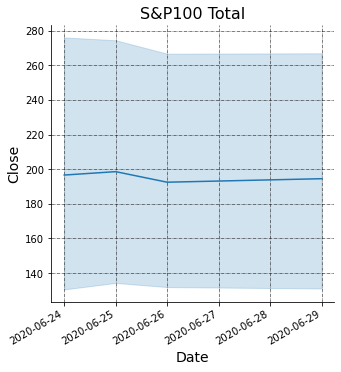

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df_Flat).fig.autofmt_xdate()

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.title('S&P100 Total', fontsize=16)
plt.ylabel('Close', fontsize=14)
plt.xlabel('Date', fontsize=14)

jpg_name = 'SP100_total.jpg'
plt.savefig(jpg_name, bbox_inches='tight')

pd.options.display.float_format = '{:,.2%}'.format
display(tickers_volatile), display(tickers_bestPerformed)

In [78]:
#pd.options.display.float_format = '{:,.2f}'.format
dataToExport = df.loc[tickers_bestPerformed.index].unstack(0).describe()
dataToExport = dataToExport.transpose().reset_index().groupby(['Symbol', 'level_0']).sum().round(2)

dataToExport.rename_axis(index={"level_0":"Type"}, inplace=True)
dataToExport

count        mean         std         min         25%  \
Symbol Type                                                               
ACN    Adj Close    4.0      211.04        6.54      201.84      209.81   
       Close        4.0      211.04        6.54      201.84      209.81   
       High         4.0      213.90        4.75      207.40      211.89   
       Low          4.0      208.31        5.23      200.50      207.74   
       Open         4.0      211.36        4.75      205.51      208.99   
       Volume       4.0  2941859.00  1541144.06   975136.00  2309059.00   
ALL    Adj Close    4.0       94.73        1.30       92.95       94.17   
       Close        4.0       94.73        1.30       92.95       94.17   
       High         4.0       95.84        0.09       95.70       95.83   
       Low          4.0       93.61        0.74       92.88       93.16   
       Open         4.0       94.81        1.11       93.37       94.22   
       Volume       4.0  1796055.50  1055070.69   369922.00  1331780.50   
DOW    Adj Close    4.0       39.82        1.07       38.45       39.46   
       Close        4.0       39.82        1.07       38.45       39.46   
       High         4.0       40.47        0.55       40.00       40.02   
       Low          4.0       38.73        1.06       37.68       38.16   
       Open         4.0       39.63        1.17       38.00       39.17   
       Volume       4.0  6201823.75  2487273.23  2780395.00  5185273.75   
LLY    Adj Close    4.0      161.13        2.78      157.03      160.61   
       Close        4.0      161.13        2.78      157.03      160.61   
       High         4.0      162.79        2.03      159.79      162.49   
       Low          4.0      158.56        2.39      156.33      156.62   
       Open         4.0      160.59        2.97      157.64      158.32   
       Volume       4.0  3280834.50  1777108.10  1001538.00  2572384.50   
SPG    Adj Close    4.0       64.78        2.17       61.90       64.18   
       Close        4.0       64.78        2.17       61.90       64.18   
       High         4.0       66.74        1.51       64.69       66.14   
       Low          4.0       62.11        0.87       61.29       61.41   
       Open         4.0       64.43        2.39       62.64       63.13   
       Volume       4.0  8364631.00  3001324.89  4533824.00  6707456.00   

                         50%          75%          max  
Symbol Type                                             
ACN    Adj Close      212.50       213.73       217.32  
       Close          212.50       213.73       217.32  
       High           215.16       217.17       217.89  
       Low            210.61       211.18       211.50  
       Open           211.57       213.94       216.78  
       Volume     3051050.00   3683850.00   4690200.00  
ALL    Adj Close       95.07        95.63        95.83  
       Close           95.07        95.63        95.83  
       High            95.88        95.88        95.90  
       Low             93.48        93.93        94.60  
       Open            95.03        95.62        95.80  
       Volume     2035350.00   2499625.00   2743600.00  
DOW    Adj Close       39.89        40.25        41.06  
       Close           39.89        40.25        41.06  
       High            40.38        40.82        41.12  
       Low             38.52        39.09        40.19  
       Open            39.96        40.42        40.60  
       Volume     6847050.00   7863600.00   8332800.00  
LLY    Adj Close      162.32       162.84       162.86  
       Close          162.32       162.84       162.86  
       High           163.59       163.89       164.21  
       Low            158.44       160.39       161.03  
       Open           160.44       162.71       163.85  
       Volume     3415700.00   4124150.00   5290400.00  
SPG    Adj Close       65.03        65.62        67.17  
       Close           65.03        65.62        67.17  
       High          

In [79]:
#format_column_percentage(dataToExport, dataToExport.columns[1:])

dataToExport2 = df.loc[tickers_bestPerformed.index].unstack(0).describe().stack(0)
dataToExport2

# Create PDF file

In [99]:
today = dt.datetime.today().strftime('%Y-%m-%d')
pdf_file_name = "Report "+ today +".pdf"

In [108]:
def PrepareTableForReportLab(dataframe):
    
    data = dataframe

    'handling grouped first index column'
    a= []
    for i in range(len(data)):
        #print(i, data.index.get_level_values(0)[i])
        if data.index.get_level_values(0)[i-1] == data.index.get_level_values(0)[i]:
            a.append(i)
    a.sort(reverse=True)

    as_list = data.index.get_level_values(0).tolist()
    for i in a:
        as_list[i] = ""

        
    'flat dataframe'
    data = data.reset_index()
    'remove duplicated values from first column which was index before resetting index'
    first_col_name = data.columns[0]
    data[first_col_name] = as_list 
    
    #data = dataframe.reset_index()
    #colwidths = 800/len(data.columns) 
    data = [data.columns.to_list()] + data.values.tolist() 

    #tbl = Table(data) # 
    tbl = Table(data) #, colwidths ) #, rowheights)
    tbl.setStyle(TableStyle([
    ('INNERGRID', (0, 0), (-1, -1), 0.25, colors.black),
    ('BOX', (0, 0), (-1, -1), 0.25, colors.black),
    ('ALIGN', (1,1), (-1,-1), 'RIGHT'),
    ('BACKGROUND', (0,0), (-1,0), colors.Color(0,0.7,0.7))
    ]))
    
    return tbl

In [109]:
story = []

In [110]:
story.append(Paragraph("Highest growth rates", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest growth rates in past <i>" + str(days_to_lookback) + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append((PrepareTableForReportLab(dataToExport)))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_bestPerformed))
story.append(PageBreak())

story.append(Paragraph("Volatility", getSampleStyleSheet()['Heading1']))
story.append(Paragraph("highest volatility rates in past <i>" + str(days_to_lookback)  + " days</i>.",  getSampleStyleSheet()['Normal']))
story.append(Spacer(1,20))
story.append(PrepareTableForReportLab(tickers_volatile))
story.append(PageBreak())

#### Add graph images saved in the timestamped folder

In [111]:
for file in sorted(os.listdir(reportDir), key=os.path.getmtime):
    if file.endswith('jpg'):
        temp = file
        temp = 'image_'+ temp
        print(temp)
        temp = Image(file)
        #story.append(Spacer(1, 20))
        story.append(temp)

image_highest growth closing price.jpg
image_highest growth closing pct change.jpg
image_1.jpg
image_2.jpg
image_SP100_total.jpg


In [112]:
story.append(PageBreak())
story.append(PrepareTableForReportLab(news_df))

In [113]:
doc = SimpleDocTemplate(pdf_file_name, pagesize = landscape(letter), topMargin = inch * .25, bottomMargin = inch * .25)
doc.build(story)

In [115]:
#Open pdf file generated
subprocess.run(['open', pdf_file_name], check=True)

CompletedProcess(args=['open', 'Report 2020-06-29.pdf'], returncode=0)